In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns; sns.set_style("ticks")

### Open mock data

In [2]:
x_cluster_r = np.loadtxt("cluster-mock-R/xa.txt")
y_cluster_r = np.loadtxt("cluster-mock-R/ya.txt")
z_cluster_r = np.loadtxt("cluster-mock-R/za.txt")
mag_cluster_r = np.loadtxt( "cluster-mock-R/mag_cluster.txt")

xcampo_r = np.loadtxt("cluster-mock-R/xcampo.txt")
ycampo_r = np.loadtxt("cluster-mock-R/ycampo.txt")
zcampo_r = np.loadtxt("cluster-mock-R/zcampo.txt")
mag_campo_r = np.loadtxt("cluster-mock-R/mag_campo.txt")

ra = np.concatenate((xcampo_r, x_cluster_r))
dec = np.concatenate((ycampo_r, y_cluster_r))
zml = np.concatenate((zcampo_r, z_cluster_r))
rpetro = np.concatenate((mag_campo_r, mag_cluster_r))

In [3]:
#Defining values for the cluster mock

Ragl = 5 #in "degrees". This is the value we set for the cluster radius in the mock
sigma_z = 0.012 #I think this has to be a function of magnitude (use sigma_nmad(r))
zagl = 0.01

ra0 = 0.0
dec0 = 0.0

### Use KNN to estimate density

In [4]:
x = np.deg2rad(ra) #like longitude
y = np.deg2rad(dec) #like latitude

xbin_size = 200
ybin_size = 200

xbins=xbin_size*1j
ybins=ybin_size*1j

xx, yy = np.mgrid[x.min():x.max():xbins, y.min():y.max():ybins]

In [5]:
#AstroML.KNeighborsDensity
"""
Tools for density estimation
See also:
- sklearn.mixture.gmm : gaussian mixture models
- sklearn.neighbors.KernelDensity : Kernel Density Estimation (version 0.14+)
- astroML.density_estimation.XDGMM : extreme deconvolution
- scipy.spatial.gaussian_kde : a gaussian KDE implementation
"""
import numpy as np
from scipy import special
from sklearn.base import BaseEstimator
from sklearn.neighbors import BallTree


def n_volume(r, n):
    """compute the n-volume of a sphere of radius r in n dimensions"""
    return np.pi ** (0.5 * n) / special.gamma(0.5 * n + 1) * (r ** n)


class KNeighborsDensity(BaseEstimator):
    """K-neighbors density estimation
    Parameters
    ----------
    method : string
        method to use.  Must be one of ['simple'|'bayesian'] (see below)
    n_neighbors : int
        number of neighbors to use
    Notes
    -----
    The two methods are as follows:
    - simple:
        The density at a point x is estimated by n(x) ~ k / r_k^n
    - bayesian:
        The density at a point x is estimated by n(x) ~ sum_{i=1}^k[1 / r_i^n].
    See Also
    --------
    KDE : kernel density estimation
    """
    def __init__(self, method='bayesian', n_neighbors=10):
        if method not in ['simple', 'bayesian']:
            raise ValueError("method = %s not recognized" % method)

        self.n_neighbors = n_neighbors
        self.method = method

    def fit(self, X):
        """Train the K-neighbors density estimator
        Parameters
        ----------
        X : array_like
            array of points to use to train the KDE.  Shape is
            (n_points, n_dim)
        """
        self.X_ = np.atleast_2d(X)

        if self.X_.ndim != 2:
            raise ValueError('X must be two-dimensional')

        self.bt_ = BallTree(self.X_, metric="haversine")

        return self

    def eval(self, X):
        """Evaluate the kernel density estimation
        Parameters
        ----------
        X : array_like
            array of points at which to evaluate the KDE.  Shape is
            (n_points, n_dim), where n_dim matches the dimension of
            the training points.
        Returns
        -------
        dens : ndarray
            array of shape (n_points,) giving the density at each point.
            The density will be normalized for metric='gaussian' or
            metric='tophat', and will be unnormalized otherwise.
        """
        X = np.atleast_2d(X)
        if X.ndim != 2:
            raise ValueError('X must be two-dimensional')

        if X.shape[1] != self.X_.shape[1]:
            raise ValueError('dimensions of X do not match training dimension')

        dist, ind = self.bt_.query(X, self.n_neighbors, return_distance=True)

        k = float(self.n_neighbors)
        ndim = X.shape[1]

        if self.method == 'simple':
            return k / n_volume(dist[:, -1], ndim)

        elif self.method == 'bayesian':
            # XXX this may be wrong in more than 1 dimension!
            return (k * (k + 1) * 0.5 / n_volume(1, ndim)
                    / (dist ** ndim).sum(1))
        else:
            raise ValueError("Unrecognized method '%s'" % self.method)


In [6]:
def knn2D(x, y, K, xbins=200j, ybins=200j, **kwargs): 
    """Build 2D Nearest-Neighbor density estimate (KNN)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    knd = KNeighborsDensity(method="bayesian", n_neighbors=K)
    knd.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = knd.eval(xy_sample)
    return xx, yy, np.reshape(z, xx.shape)

In [42]:
K = 100
xx, yy, zz = knn2D(x, y, K=K, xbins=xbins, ybins=ybins)

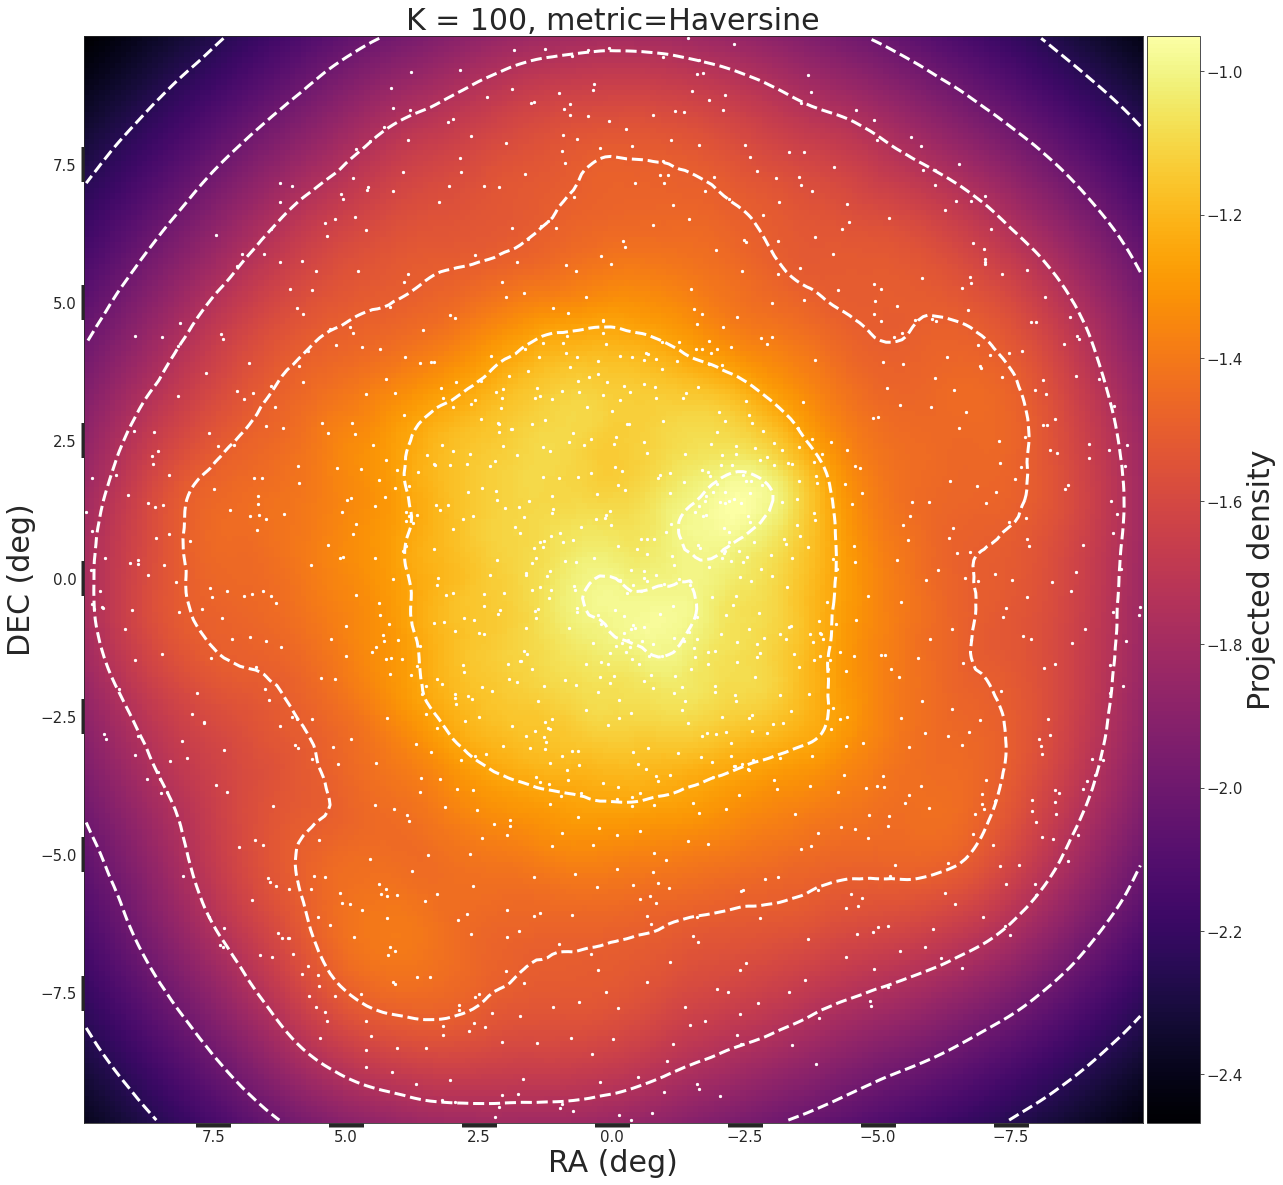

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

conversion_factor = np.rad2deg(1)**2 * K

fontsize = 30
labelsize = 15

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
sc1 = ax.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz/conversion_factor), cmap='inferno')
ax.contour(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz/conversion_factor), colors='white', levels=6, extend='min', linewidths=3)
ax.scatter(np.rad2deg(x), np.rad2deg(y), s=5, color='white')
ax.set_ylabel("DEC (deg)", fontsize=fontsize)
ax.set_xlabel("RA (deg)", fontsize=fontsize)
ax.set_title("K = {:1d}, metric=Haversine".format(K), fontsize=fontsize)

divider = make_axes_locatable(ax)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label="Projected density", fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

# ax.legend(fontsize=fontsize*0.8)
ax.xaxis.set_tick_params(labelsize=labelsize, width=35)
ax.yaxis.set_tick_params(labelsize=labelsize, width=35)
    
    
# ax.set_ylim(-48)
# ax.set_xlim(150)
ax.invert_xaxis()

### Compute mean density in the region of the cluster (R < 5°) and in the region of the field (5° < R < 10°)

In [15]:
def haversine(x1, y1, x2, y2):
    '''
    Calculate the distance between points (x1, y1) and (x2, y2) using haversine metric
    
    Basically, x1 and x2 are the right ascencions, and y1 and y2 are the declinations
    '''
    
    return 2*np.arcsin(np.sqrt(np.sin((x2-x1)/2)**2 + np.cos(x1)*np.cos(x2)*np.sin((y2-y1)/2)**2))

In [33]:
dists = np.rad2deg(haversine(xx, yy, ra0, dec0))

In [44]:
mask_field = (dists > 5) & (dists < 10)
mask_cluster = dists < 5

mean_field_density = np.sum(zz[mask_field]) / (np.pi * (10**2 - 5**2))
mean_cluster_density = np.sum(zz[mask_cluster]) / (np.pi * 5**2)

In [45]:
mean_field_density / mean_cluster_density

0.40726236945847055